# Optimization via Stochastic Gradient Descent

In [1]:
import sys; sys.path.append("..")
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
from tqdm import tqdm
from itertools import combinations
from utils.optimization import gd
from utils.PCAClassifier import PCAClassifier
from utils.SVDClassifier import SVDClassifier

np.random.seed(42)

In [2]:
def sgd(loss, grad_loss, w0, data, batch_size, n_epochs, lr, random_seed=42):
    X, y = data
    data_size = X.shape[1]
    curr_w = w0
    history_w = [w0]
    history_loss = [loss(w0, X, y)]
    history_grad = [grad_loss(w0, X, y)]
    history_err = [np.linalg.norm(history_grad[-1], 2)]

    for _ in range(n_epochs):
        idxs = np.arange(0, data_size)
        np.random.default_rng(random_seed).shuffle(idxs)

        for i in range(math.ceil(data_size / batch_size)):
            batch_idxs = idxs[i*batch_size : (i+1)*batch_size]
            batch_X = X[:, batch_idxs]
            batch_y = y[batch_idxs]

            curr_w = curr_w - lr*grad_loss(curr_w, batch_X, batch_y)

        history_w.append(curr_w)
        history_loss.append(loss(curr_w, X, y))
        history_grad.append(grad_loss(curr_w, X, y))
        history_err.append( np.linalg.norm(history_grad[-1], 2) )

    return history_w, history_loss, history_grad, history_err

## Data preparation

In [3]:
def train_test_split(X, Y, train_size, random_seed=42):
    rng = np.random.default_rng(random_seed)

    idxs = np.arange(0, X.shape[1])
    rng.shuffle(idxs)
    X_train = X[:, idxs[:train_size]]
    Y_train = Y[idxs[:train_size]]
    X_test = X[:, idxs[train_size:]]
    Y_test = Y[idxs[train_size:]]

    return X_train, Y_train, X_test, Y_test


def filterDigits(X, Y, digits):
    select_mask = np.full(Y.shape, False)
    for d in digits:
        select_mask |= (Y == d)
    return X[:, select_mask], Y[select_mask]

def onehot(Y_digits):
    digits = np.unique(Y_digits).tolist()
    return np.array([ [0]*((digits.index(d))) + [1] + [0]*((len(digits) - digits.index(d)-1)) for d in Y_digits ])

def addColumn(A):
    out = np.ones((A.shape[0]+1, A.shape[1]))
    out[1:, :] = A
    return out

def createDataset(X, Y, digits, classification_type="binary", train_ratio=0.75):
    X = addColumn(X)
    X, Y = filterDigits(X, Y, digits)

    if classification_type == "binary":
        Y[Y == digits[0]] = 0
        Y[Y == digits[1]] = 1
    elif classification_type == "multi":
        Y = onehot(Y)
    else: raise Exception("Invalid type")

    return train_test_split(X, Y, int(train_ratio*X.shape[1]))

In [4]:
data = pd.read_csv("../homework2/data/data.csv")
data = data.to_numpy()

full_X = data[:, 1:].T
full_Y = data[:, 0].T
print(full_X.shape, full_Y.shape)

(784, 42000) (42000,)


## Binary classification

In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def f(w, x):
    return sigmoid(x.T @ w)


def mse(fn, w, X, y):
    return (1/2) * np.linalg.norm(fn(w, X) - y, 2)**2

def mse_grad(fn, w, X, y):
    N = X.shape[1]
    fn_X = fn(w, X)
    return ( X @ (fn_X * (1-fn_X) * (fn_X - y)) )


def loss(w, X, Y):
    N = X.shape[1]
    return (1/N) * mse(f, w, X, Y)

def grad_loss(w, X, Y):
    N = X.shape[1]
    return (1/N) * mse_grad(f, w, X, Y)

In [6]:
def evaluate(w, X_test, Y_test, threshold=0.5):
    correct = 0
    N = X_test.shape[1]

    for i in range(N):
        pred_prob = f(w, X_test[:, i])
        
        if pred_prob >= threshold:
            pred = 1
        else:
            pred = 0
            
        if pred == Y_test[i]:
            correct += 1

    return correct, correct / N

In [7]:
digits = [8, 9]
X_train, Y_train, X_test, Y_test = createDataset(full_X, full_Y, digits, classification_type="binary")
print(f"Train set -- {(Y_train == 0).sum()} class 1 ({digits[0]}) | {(Y_train == 1).sum()} class 2 ({digits[1]})")
print(f" Test set -- {(Y_test == 0).sum()} class 1 ({digits[0]}) | {(Y_test == 1).sum()} class 2 ({digits[1]})")

Train set -- 3039 class 1 (8) | 3149 class 2 (9)
 Test set -- 1024 class 1 (8) | 1039 class 2 (9)


/tmp/ipykernel_316855/1314768227.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Accuracy: 0.9733397964129908


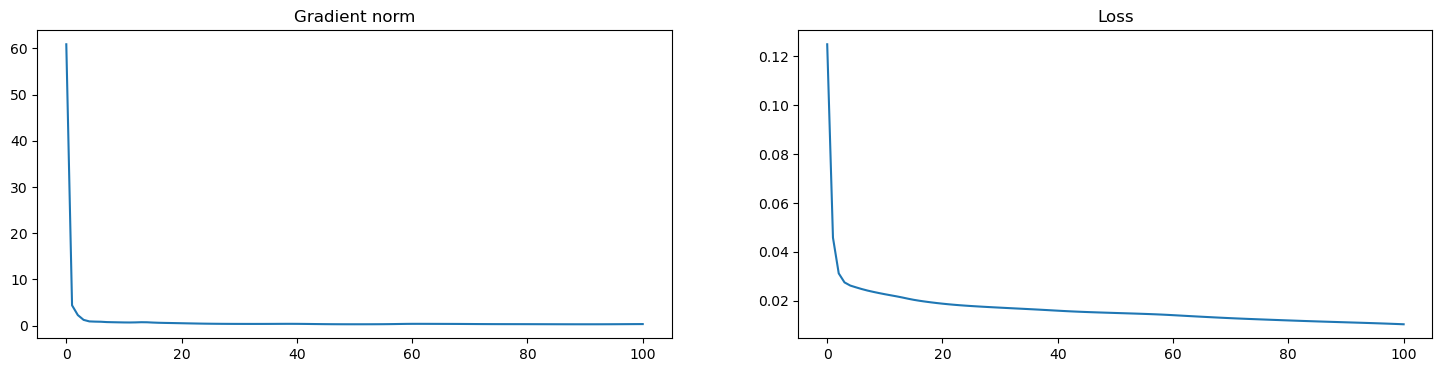

In [8]:
history_w, curr_k, history_loss, history_grad, history_err = gd(loss, grad_loss, np.zeros(X_train.shape[0]), (X_train, Y_train), 100, 1e-6, 1e-6)

correct, accuracy = evaluate(history_w[-1], X_test, Y_test)
print(f"Accuracy: {accuracy}")

plt.figure(figsize=(18, 4))

plt.subplot(1, 2, 1)
plt.plot(range(len(history_err)), history_err)
plt.title("Gradient norm")

plt.subplot(1, 2, 2)
plt.plot(range(len(history_loss)), history_loss)
plt.title("Loss")
plt.show()

Accuracy: 0.9844886088221038


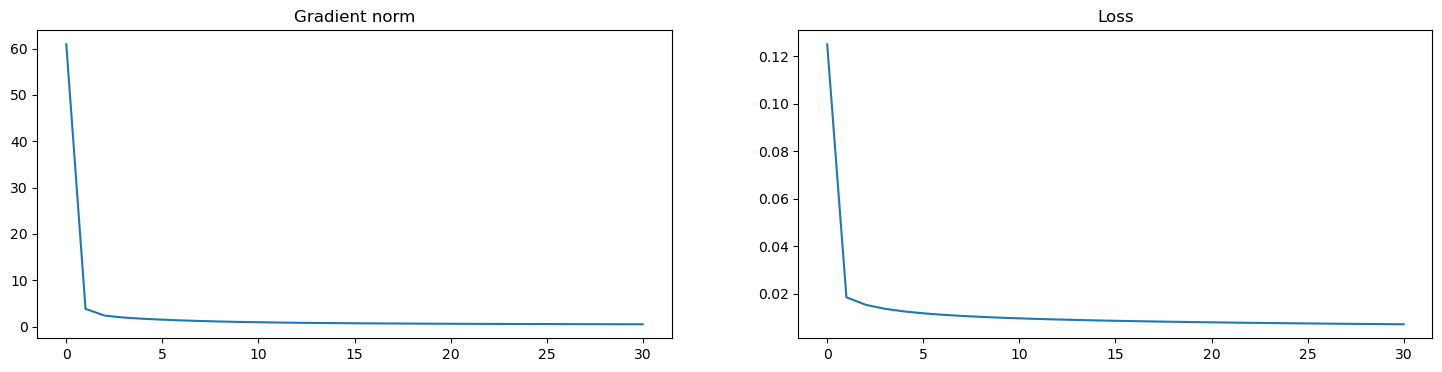

In [9]:
history_w, history_loss, history_grad, history_err = sgd(loss, grad_loss, np.zeros(X_train.shape[0]), (X_train, Y_train), batch_size=500, n_epochs=30, lr=3e-5)

correct, accuracy = evaluate(history_w[-1], X_test, Y_test)
print(f"Accuracy: {accuracy}")

plt.figure(figsize=(18, 4))

plt.subplot(1, 2, 1)
plt.plot(range(len(history_err)), history_err)
plt.title("Gradient norm")

plt.subplot(1, 2, 2)
plt.plot(range(len(history_loss)), history_loss)
plt.title("Loss")
plt.show()

In [10]:
class BinaryLogisticRegression:
    def __init__(self):
        self.w = None

    def fit(self, X_train, Y_train, algorithm="sgd", w0=None, batch_size=500, epochs=30, lr=3e-5, tol_loss=1e-6, tol_w=1e-6):
        if algorithm == "sgd":
            history_w, history_loss, history_grad, history_err = sgd(
                loss, grad_loss, 
                w0 if w0 is not None else np.zeros(X_train.shape[0]), 
                (X_train, Y_train), 
                batch_size, epochs, lr
            )
        else:
            history_w, curr_k, history_loss, history_grad, history_err = gd(
                loss, grad_loss, 
                w0 if w0 is not None else np.zeros(X_train.shape[0]), 
                (X_train, Y_train), epochs, tol_loss, tol_w
            )
            
        self.w = history_w[-1]
        return self

    def predict(self, X, threshold=0.5):
        if X.ndim == 1:
            return 1 if f(self.w, X) >= threshold else 0
        else:
            out = []

            for i in range(X.shape[1]):
                out.append(1 if f(self.w, X[:, i]) >= threshold else 0)
            return np.array(out)     


def evaluateBinary(model, X_test, Y_test):
    correct = 0
    for i in range(X_test.shape[1]):
        if model.predict(X_test[:, i]) == Y_test[i]:
            correct += 1
    return correct / X_test.shape[1]

In [11]:
def binaryDigitEvaluation(digit1, digit2):
    X_train, Y_train, X_test, Y_test = createDataset(full_X, full_Y, [digit1, digit2])

    model_sgd = BinaryLogisticRegression().fit(X_train, Y_train, algorithm="sgd")
    model_gd = BinaryLogisticRegression().fit(X_train, Y_train, algorithm="gd")

    accuracy_sgd = evaluateBinary(model_sgd, X_test, Y_test)
    accuracy_gd = evaluateBinary(model_gd, X_test, Y_test)
    
    print(f"------ Classifying {digit1} {digit2} ------")
    print(f"||w_sgd - w_gd||_2 = {np.linalg.norm(model_sgd.w - model_gd.w)}")
    print(f"SGD acc. = {accuracy_sgd} | GD acc. {accuracy_gd}")

binaryDigitEvaluation(0, 1)
binaryDigitEvaluation(8, 9)

/tmp/ipykernel_316855/1314768227.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


------ Classifying 0 1 ------
||w_sgd - w_gd||_2 = 0.10785693214214206
SGD acc. = 0.9986388384754991 | GD acc. 0.9936479128856625
------ Classifying 8 9 ------
||w_sgd - w_gd||_2 = 0.049122260503937816
SGD acc. = 0.9844886088221038 | GD acc. 0.9626757149781872


In [12]:
def trainModels(train_ratio):
    models_sgd = {}
    models_gd = {}
    models_svd = {}
    models_pca = {}

    for i, j in tqdm([*combinations(range(0, 10), 2)]):
        X_train, Y_train, X_test, Y_test = createDataset(full_X, full_Y, [i, j], classification_type="binary", train_ratio=train_ratio)
        
        model_sgd = BinaryLogisticRegression().fit(X_train, Y_train, "sgd", epochs=30)
        models_sgd[(i,j)] = models_sgd[(j, i)] = (model_sgd, X_test, Y_test)

        model_gd = BinaryLogisticRegression().fit(X_train, Y_train, "gd", epochs=100)
        models_gd[(i,j)] = models_gd[(j, i)] = (model_gd, X_test, Y_test)

        model_svd = SVDClassifier().fit(X_train, Y_train)
        models_svd[(i,j)] = models_svd[(j, i)] = (model_svd, X_test, Y_test)

        model_pca = PCAClassifier().fit(X_train, Y_train)
        models_pca[(i,j)] = models_pca[(j, i)] = (model_pca, X_test, Y_test)

    return models_sgd, models_gd, models_svd, models_pca


def accuracyHeatMapData(models):
    accuracies = np.zeros((10, 10))

    for i in range(0, 10):
        for j in range(i, 10):
            if i == j: 
                accuracies[i, j] = 1
                continue
            model, X_test, Y_test = models[(i, j)]
            accuracies[i, j] = accuracies[j, i] = evaluateBinary(model, X_test, Y_test)

    return accuracies


def paramsDiffHeatMapData(models_sgd, models_gd):
    differences = np.zeros((10, 10))

    for i in range(0, 10):
        for j in range(i, 10):
            if i == j: 
                differences[i, j] = None
                continue
            model_sgd, _, _ = models_sgd[(i, j)]
            model_gd, _, _ = models_gd[(i, j)]
            differences[i, j] = differences[j, i] = np.linalg.norm(model_sgd.w - model_gd.w, 2)

    return differences

  0%|          | 0/45 [00:00<?, ?it/s]

/tmp/ipykernel_316855/1314768227.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
100%|██████████| 45/45 [03:09<00:00,  4.22s/it]


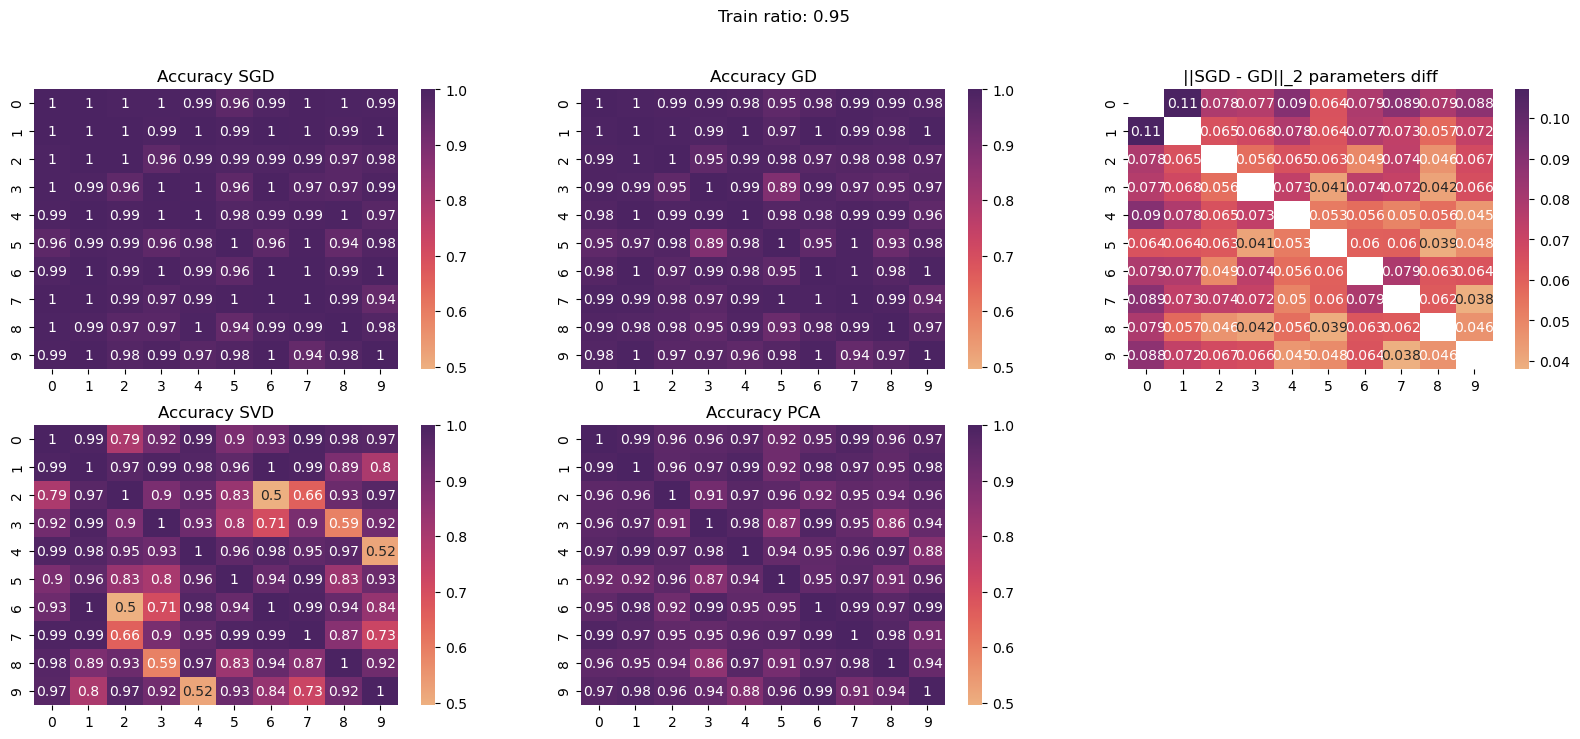

  0%|          | 0/45 [00:00<?, ?it/s]/tmp/ipykernel_316855/1314768227.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
100%|██████████| 45/45 [02:14<00:00,  2.99s/it]


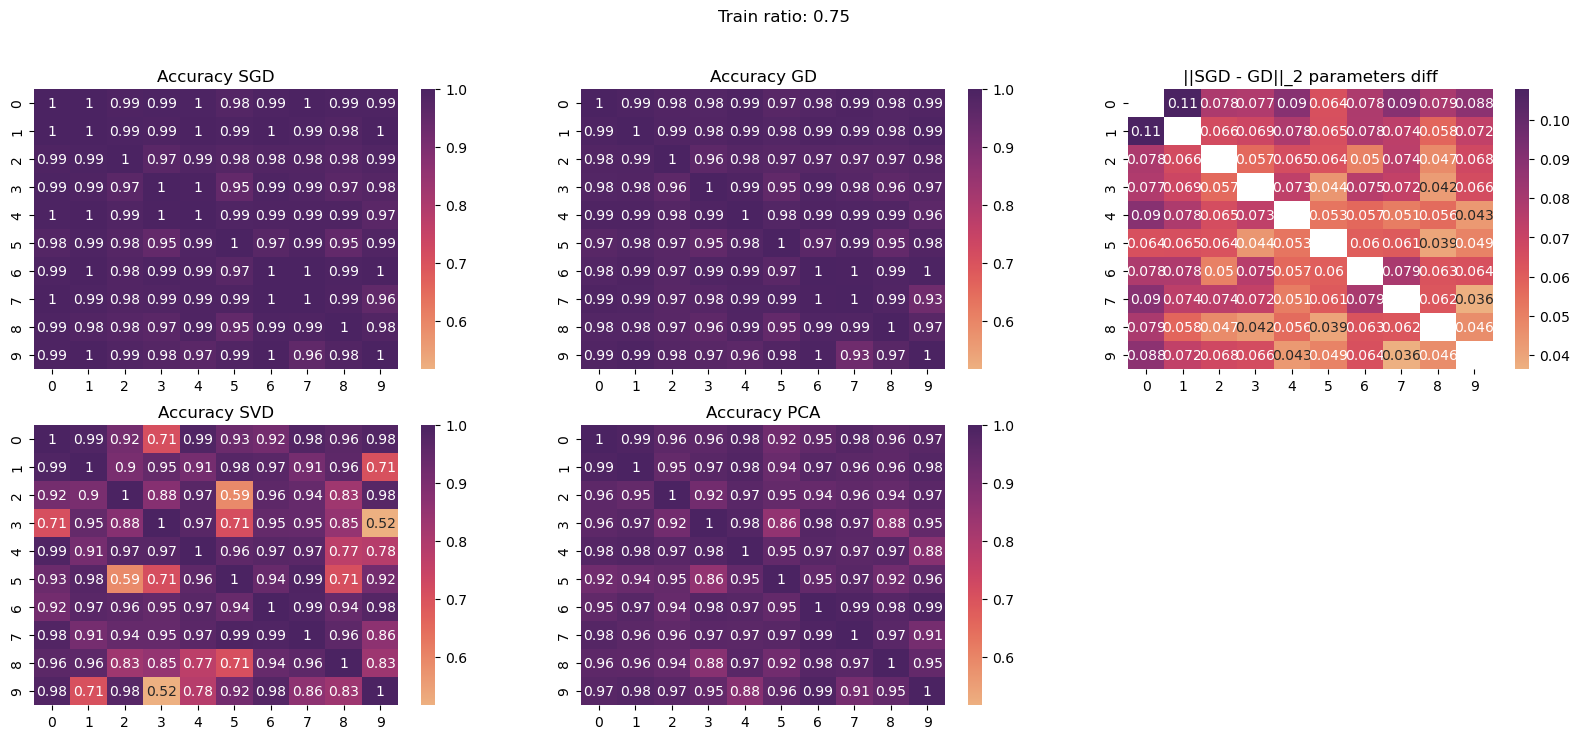

  0%|          | 0/45 [00:00<?, ?it/s]/tmp/ipykernel_316855/1314768227.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
100%|██████████| 45/45 [01:17<00:00,  1.72s/it]


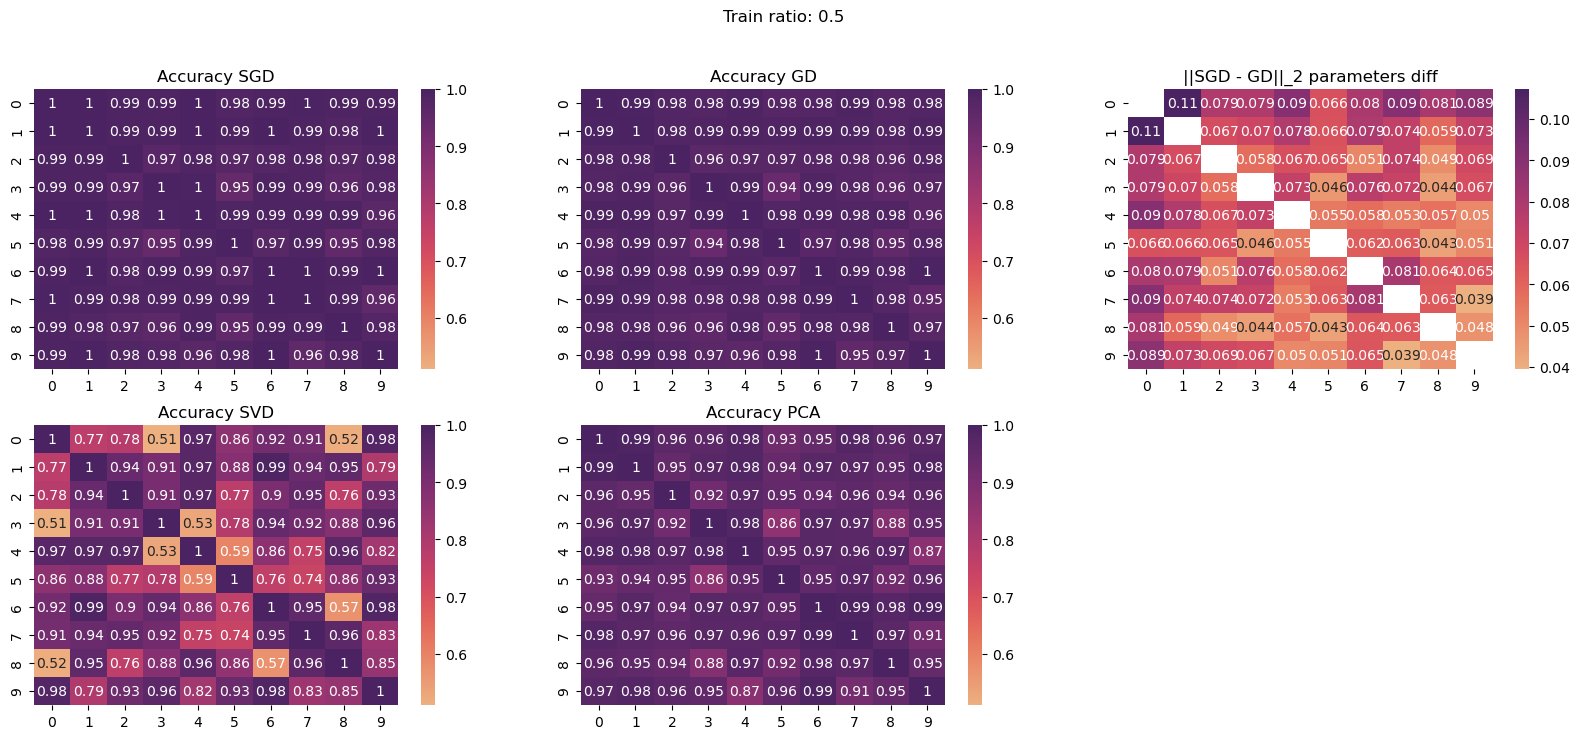

  0%|          | 0/45 [00:00<?, ?it/s]/tmp/ipykernel_316855/1314768227.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
100%|██████████| 45/45 [00:32<00:00,  1.40it/s]


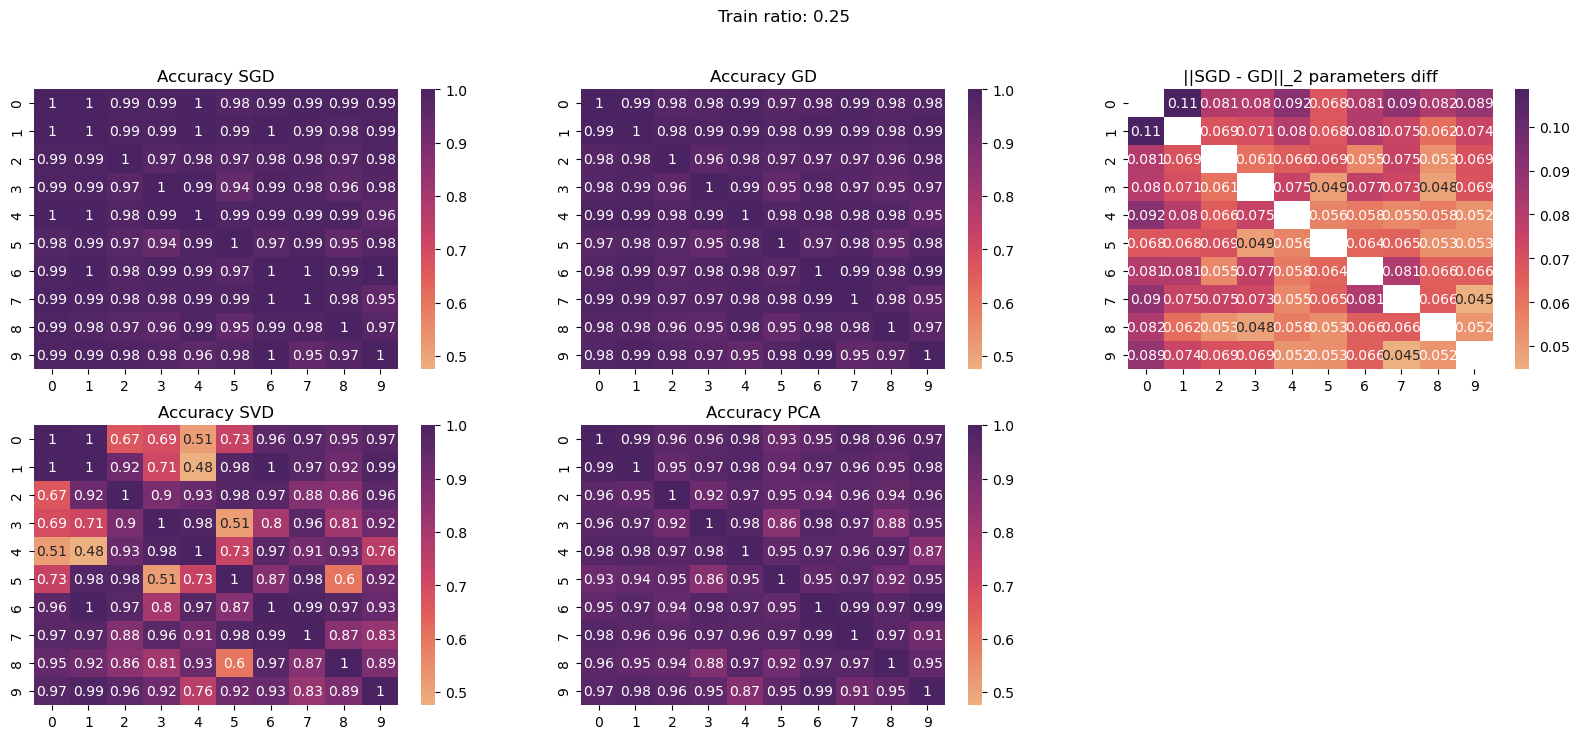

In [13]:
to_test_ratio = [0.95, 0.75, 0.5, 0.25]

for i, ratio in enumerate(to_test_ratio):
    models_sgd, models_gd, models_svd, models_pca = trainModels(ratio)

    accuracies_sgd = accuracyHeatMapData(models_sgd)
    accuracies_gd = accuracyHeatMapData(models_gd)
    accuracies_svd = accuracyHeatMapData(models_svd)
    accuracies_pca = accuracyHeatMapData(models_pca)
    param_diffs = paramsDiffHeatMapData(models_sgd, models_gd)


    plt.figure(figsize=(20, 8))
    plt.suptitle(f"Train ratio: {ratio}")
    
    hm_vmin = min(np.min(accuracies_sgd), np.min(accuracies_gd), np.min(accuracies_svd), np.min(accuracies_pca))
    hm_vmax = max(np.max(accuracies_sgd), np.max(accuracies_gd), np.max(accuracies_svd), np.max(accuracies_pca))

    plt.subplot(2, 3, 1)
    plt.title(f"Accuracy SGD")
    sns.heatmap(accuracies_sgd, annot=True,  
        cmap=sns.color_palette("flare", as_cmap=True), 
        vmin=hm_vmin, vmax=hm_vmax
    )

    plt.subplot(2, 3, 2)
    plt.title(f"Accuracy GD")
    sns.heatmap(accuracies_gd, annot=True,  
        cmap=sns.color_palette("flare", as_cmap=True), 
        vmin=hm_vmin, vmax=hm_vmax
    )
    
    plt.subplot(2, 3, 3)
    plt.title(f"||SGD - GD||_2 parameters diff")
    sns.heatmap(param_diffs, annot=True,  cmap=sns.color_palette("flare", as_cmap=True))

    plt.subplot(2, 3, 4)
    plt.title(f"Accuracy SVD")
    sns.heatmap(accuracies_svd, annot=True,  
        cmap=sns.color_palette("flare", as_cmap=True), 
        vmin=hm_vmin, vmax=hm_vmax
    )

    plt.subplot(2, 3, 5)
    plt.title(f"Accuracy PCA")
    sns.heatmap(accuracies_pca, annot=True,  
        cmap=sns.color_palette("flare", as_cmap=True), 
        vmin=hm_vmin, vmax=hm_vmax
    )

    plt.show()

## Multi-class classification

\begin{equation*}
    w: N \times 3
\end{equation*}

\begin{split}
    MSE&: (N \times 3) \rightarrow 1 \\
    \nabla MSE&: (N \times 3) \rightarrow (N \times 3)
\end{split}

\begin{split}
    \sigma&: 3 \rightarrow 3 \\
    \nabla\sigma&: 3 \rightarrow (3 \times 3)
\end{split}

\begin{split}
    f&: (N \times 3) \rightarrow 3 \\
    \nabla f&: (N \times 3) \rightarrow (3 \times N \times 3)
\end{split}

\begin{equation*}
    \sigma_i(z) = \frac{e^{z_i}}{\sum_{j=1}^N e^{z_j}} 
    \hspace{2cm} 
    \frac{\partial \sigma(z_i)}{\partial z_j} = \sigma(z_i) (\delta_{ij} - \sigma(z_j)) 
    \hspace{0.5cm}
    \delta_{ij} = \begin{cases} 1 & \text{if } i=j \\ 0 & \text{if } i \neq j \end{cases}
\end{equation*}


In [14]:
def softmax(z):
    # exp_z = np.exp(z - np.max(z))
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z)

def softmax_grad(z):
    # grad_matr = []
    # for i in range(z.shape[0]):
    #     grad_row = []
    #     for j in range(z.shape[0]):
    #         delta = 1 if i == j else 0
    #         grad_row.append( softmax(z)[i] * (delta - softmax(z)[j]) )
    #     grad_matr.append(grad_row)
    
    # return np.array(grad_matr)

    s = softmax(z)
    return np.diag(s) - np.outer(s, s)


def f_multi(w, x):
    return softmax(x.T @ w)

def f_multi_grad(w, x):
    def __grad(a):
        grad = softmax_grad(a.T @ w)
        # return np.array([ np.outer(a.T, grad[i, :]) for i in range(grad.shape[0]) ])
        return np.einsum('ij,k->ikj', grad, a)
    
    if x.ndim == 1: return __grad(x)
    # return np.array([ __grad(x[:, i]) for i in range(x.shape[1]) ])
    return np.apply_along_axis(__grad, axis=0, arr=x).T
 

def mse(f, w, D):
    X, y = D
    return (1/2) * (np.linalg.norm(f(w, X) - y, 2)**2)

def mse_grad(f, grad_f, w, D):
    X, y = D
    N = X.shape[1]
    grad = grad_f(w, X)
    f_x = f(w, X)

    # out = [ grad[i] @ (f_x[i] - y[i]) for i in range(N) ]
    out = np.einsum('Bijk,Bk->Bij', grad, (f_x - y))

    return np.mean(out, axis=0).T


def loss_multi(w, X, Y):
    N = X.shape[1]
    return (1/N) * mse(f_multi, w, (X, Y))

def grad_loss_multi(w, X, Y):
    N = X.shape[1]
    return (1/N) * mse_grad(f_multi, f_multi_grad, w, (X, Y))

In [15]:
def evaluateMulti(w, X_test, Y_test):
    correct = 0
    N = X_test.shape[1]

    for i in range(N):
        pred_probs = f_multi(w, X_test[:, i])
        
        if np.argmax(pred_probs) == np.argmax(Y_test[i]):
            correct += 1

    return correct, correct / N

In [16]:
digits = [0, 6, 9]
X_train, Y_train, X, Y = createDataset(full_X, full_Y, digits, classification_type="multi")

for digit, train_size, test_size in zip([d for d in digits], np.sum(Y_train, axis=0), np.sum(Y, axis=0)):
    print(f"{digit} | {train_size} train -- {test_size} test")

0 | 3112 train -- 1020 test
6 | 3107 train -- 1030 test
9 | 3123 train -- 1065 test


Accuracy: 0.9756019261637239


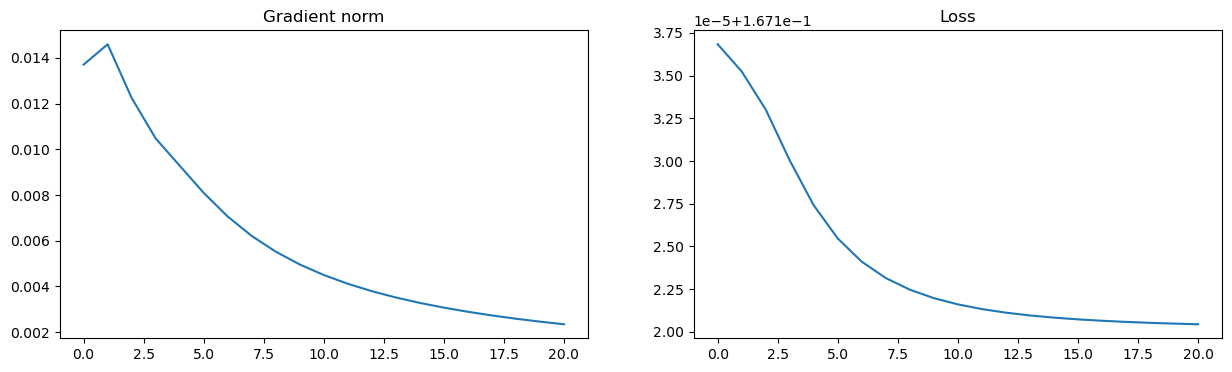

In [17]:
history_w, history_loss, history_grad, history_err = sgd(
    loss_multi, grad_loss_multi, np.zeros((X_train.shape[0], len(digits))), (X_train, Y_train), batch_size=500, n_epochs=20, lr=1e-4
)

print(f"Accuracy: {evaluateMulti(history_w[-1], X, Y)[1]}")

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(range(len(history_err)), history_err)
plt.title("Gradient norm")
plt.subplot(1, 2, 2)
plt.plot(range(len(history_loss)), history_loss)
plt.title("Loss")
plt.show()


Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 5 was incorrect on entry to DLASCL.
Accuracy: 0.9537720706260032


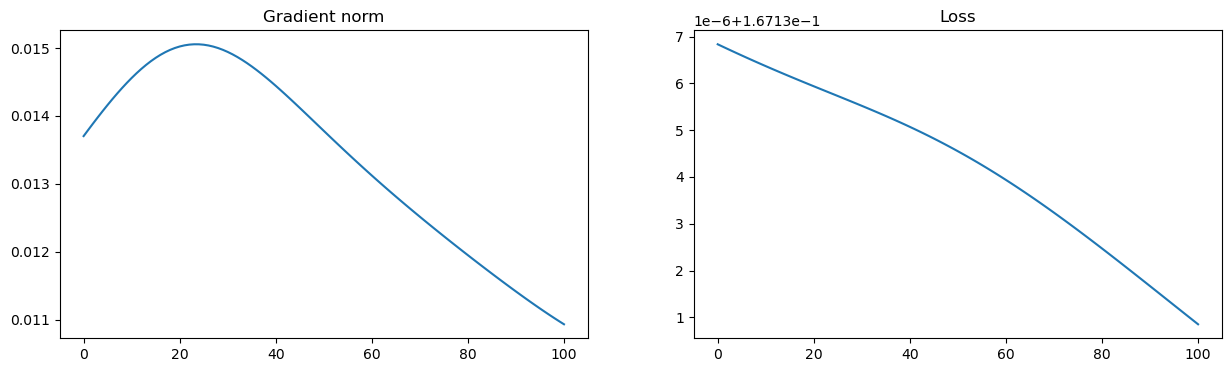

In [18]:
history_w, curr_k, history_loss, history_grad, history_err = gd(
    loss_multi, grad_loss_multi, np.zeros((X_train.shape[0], len(digits))), (X_train, Y_train), 100, 1e-6, 1e-6
)

print(f"Accuracy: {evaluateMulti(history_w[-1], X, Y)[1]}")

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(range(len(history_err)), history_err)
plt.title("Gradient norm")
plt.subplot(1, 2, 2)
plt.plot(range(len(history_loss)), history_loss)
plt.title("Loss")
plt.show()

### SVD vs PCA vs Logistic regression

In [19]:
class MNISTLogisticClassifier:
    def __init__(self):
        self.w = None
        self.digits = []

    def fit(self, X_train, Y_train, epochs=20, batch_size=500, lr=1e-4):
        self.digits = np.unique(Y_train).tolist()
        history_w, history_loss, history_grad, history_err = sgd(
            loss = loss_multi, grad_loss = grad_loss_multi, 
            w0 = np.zeros((X_train.shape[0], len(self.digits))), 
            data = (X_train, onehot(Y_train)), 
            n_epochs = epochs, 
            batch_size = batch_size, 
            lr = lr
        )
        self.w = history_w[-1]
        return self

    def predict(self, new_digit):
        preds = f_multi(self.w, new_digit)
        return self.digits[np.argmax(preds)]

In [20]:
def accuracy(classifier, X, Y):
    correct = 0
    for i in range(X.shape[1]):
        pred = classifier.predict(X[:, i])
        if pred == Y[i]: correct += 1
    return correct / X.shape[1]

def buildDataset(X, Y, digits):
    X, Y = filterDigits(X, Y, digits)
    return train_test_split(X, Y, int(0.75*X.shape[1]))


X_train, Y_train, X_test, Y_test = buildDataset(full_X, full_Y, [0, 6, 9])

pca_classifier = PCAClassifier()
pca_classifier.fit(X_train, Y_train)
print(f"PCA                 accuracy: {accuracy(pca_classifier, X_test, Y_test)}")

svd_classifier = SVDClassifier()
svd_classifier.fit(X_train, Y_train)
print(f"SVD                 accuracy: {accuracy(svd_classifier, X_test, Y_test)}")

logistic_classifier = MNISTLogisticClassifier()
logistic_classifier.fit(X_train, Y_train)
print(f"Logistic regression accuracy: {accuracy(logistic_classifier, X_test, Y_test)}")

PCA                 accuracy: 0.9550561797752809
SVD                 accuracy: 0.8157303370786517
Logistic regression accuracy: 0.9756019261637239


In [22]:
accuracies = pd.DataFrame(columns=["Digits", "SVD accuracy", "PCA accuracy", "Logistic accuracy", "Best"])

for digits in tqdm([*combinations(range(0, 10), 3)]):
    X_train, Y_train, X_test, Y_test = buildDataset(full_X, full_Y, digits)
    
    svd_classifier = SVDClassifier().fit(X_train, Y_train)
    pca_classifier = PCAClassifier().fit(X_train, Y_train)
    logistic_classifier = MNISTLogisticClassifier().fit(X_train, Y_train)
    
    svd_accuracy = accuracy(svd_classifier, X_test, Y_test)
    pca_accuracy = accuracy(pca_classifier, X_test, Y_test)
    logistic_accuracy = accuracy(logistic_classifier, X_test, Y_test)


    if pca_accuracy > logistic_accuracy and pca_accuracy > svd_accuracy:
        best = "PCA" 
    elif logistic_accuracy > pca_accuracy and logistic_accuracy > svd_accuracy:
        best = "Logistic"
    elif svd_accuracy > logistic_accuracy and svd_accuracy > pca_accuracy:
        best = "SVD"
    else: best = "---"

    accuracies.loc[len(accuracies)] = [digits, svd_accuracy, pca_accuracy, logistic_accuracy, best]

accuracies = accuracies.sort_values(by=["Logistic accuracy", "PCA accuracy", "SVD accuracy"], ascending=False)
pd.set_option("display.max_rows", None)
display(accuracies)

100%|██████████| 120/120 [1:02:33<00:00, 31.28s/it]


,Digits,SVD accuracy,PCA accuracy,Logistic accuracy,Best
2,"(0, 1, 4)",0.784916,0.969274,0.986965,Logistic
60,"(1, 6, 9)",0.980633,0.965878,0.982170,Logistic
5,"(0, 1, 7)",0.940998,0.966717,0.980938,Logistic
58,"(1, 6, 7)",0.972172,0.955535,0.977314,Logistic
7,"(0, 1, 9)",0.882190,0.958782,0.976930,Logistic
32,"(0, 6, 9)",0.815730,0.955056,0.975602,Logistic
50,"(1, 4, 6)",0.958437,0.950372,0.973325,Logistic
23,"(0, 4, 7)",0.930203,0.957805,0.972716,Logistic
43,"(1, 3, 4)",0.809277,0.959719,0.972536,Logistic
22,"(0, 4, 6)",0.880752,0.953338,0.972132,Logistic
